## Imports & Setup

In [3]:
import curie as ci
import pandas as pd
import pathlib
%matplotlib widget


class Path(pathlib.Path):
    '''Wrapper for pathlib.Path to ensure string representation is used in Spectrum class.'''
    def endswith(self, suffix):
        return str(self).endswith(suffix)
    
    def split(self, sep=None):
        return str(self).split(sep)
    
root_path = Path.cwd().parent 

spec_path  = root_path / 'spectra'
spec_calib_path = spec_path / 'calibration'
spec_exp_path   = spec_path / 'experiment'
spec_test_path  = spec_path / 'test'

## Calibration

In [4]:
calib_path_Cs = spec_calib_path / 'AA110625_Cs137.Spe'
calib_path_Ba = spec_calib_path / 'AB110625_Ba133.Spe'
calib_path_Eu = spec_calib_path / 'AC110625_Eu152.Spe'

# Extract the spectrums for calibration
cb = ci.Calibration()
sp_Cs137 = ci.Spectrum(calib_path_Cs)
sp_Ba133 = ci.Spectrum(calib_path_Ba)
sp_Eu152 = ci.Spectrum(calib_path_Eu)

# Assign isotopes to the spectrums. Our calibration samples are 100% Cs137, Ba133, and Eu152
# Note: Isotope names must be uppercase
sp_Cs137.isotopes = ['137CS']
sp_Ba133.isotopes = ['133BA']
sp_Eu152.isotopes = ['152EU']


def Ci_to_Bq(Ci):
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10  # 1 Ci = 3.7e10 Bq

# Add information about the sources
# Note: Isotope names must be uppercase
sources = [
    {'isotope': '133BA',
     'A0': Ci_to_Bq(10.78*1e-6),
     'ref_date': '10/01/1988 12:00:00'},
    {'isotope': '137CS', 
     'A0': Ci_to_Bq(11.46*1e-6), 
     'ref_date': '02/01/1979 12:00:00'},
    {'isotope': '152EU',
     'A0': 150*1e3,
     'ref_date': '01/01/2002 12:00:00'}
]

sources = pd.DataFrame(sources)
cb.calibrate([sp_Ba133, sp_Cs137, sp_Eu152], sources=sources)
cb.saveas(root_path / 'calibration.json')

Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AA110625_Cs137.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AB110625_Ba133.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AC110625_Eu152.Spe


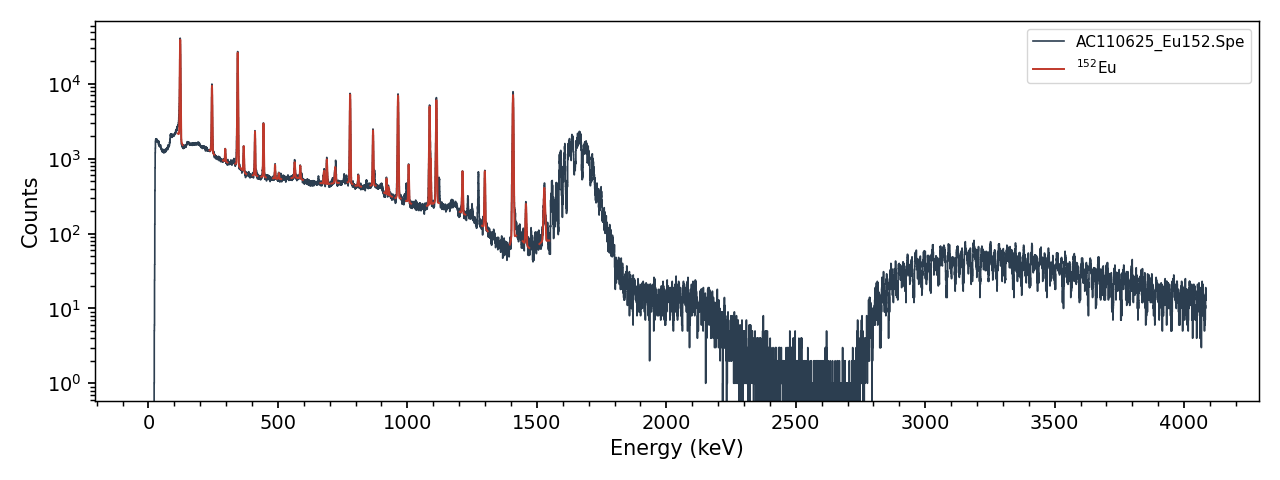

In [5]:
sp_Eu152.cb = cb
fig, ax = sp_Eu152.plot(return_plot=True)

In [6]:
sp_Eu152.summarize()

152EU - 121.7817 keV (I = 28.53%)
---------------------------------
counts: 234176 +/- 8400
decays: 2.903e+07 +/- 6.505e+06
activity (Bq): 4.459e+04 +/- 9.992e+03
activity (uCi): 1.205e+00 +/- 2.700e-01
chi2/dof: 303.154


152EU - 244.6974 keV (I = 7.55%)
--------------------------------
counts: 50366 +/- 1185
decays: 2.593e+07 +/- 1.329e+06
activity (Bq): 3.982e+04 +/- 2.041e+03
activity (uCi): 1.076e+00 +/- 5.518e-02
chi2/dof: 23.39


152EU - 295.9387 keV (I = 0.44%)
--------------------------------
counts: 2585 +/- 122
decays: 2.548e+07 +/- 1.648e+06
activity (Bq): 3.915e+04 +/- 2.531e+03
activity (uCi): 1.058e+00 +/- 6.842e-02
chi2/dof: 1.166


152EU - 344.2785 keV (I = 26.590000000000003%)
----------------------------------------------
counts: 156218 +/- 3471
decays: 2.788e+07 +/- 1.161e+06
activity (Bq): 4.283e+04 +/- 1.784e+03
activity (uCi): 1.157e+00 +/- 4.822e-02
chi2/dof: 79.987


152EU - 367.7891 keV (I = 0.859%)
---------------------------------
counts: 5456 +/- 132
decays

## Analysis

In [7]:
def get_counts(sp):
    """Get counts for isotopes in the spectrum."""
    counts = {}
    for iso, count in zip(sp.peaks['isotope'], sp.peaks['counts'].array):
        if iso in counts:
            counts[iso] += count
        else:
            counts[iso] = count
    return counts

### Job 1:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10 s 
- Num loops: 6

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6000.Spe
108AG - 632.98 keV (I = 1.76%)
------------------------------
counts: 28 +/- 4
decays: 9.263e+04 +/- 2.373e+04
activity (Bq): 9.263e+03 +/- 2.373e+03
activity (uCi): 2.503e-01 +/- 6.415e-02
chi2/dof: 1.586


110AG - 657.5 keV (I = 4.5%)
----------------------------
counts: 466 +/- 20
decays: 6.086e+05 +/- 5.169e+04
activity (Bq): 6.086e+04 +/- 5.169e+03
activity (uCi): 1.645e+00 +/- 1.397e-01
chi2/dof: 1.55


None
0    108AG
1    110AG
Name: isotope, dtype: object
---
<NumpyExtensionArray>
[28.47216339980719, 466.88839923376696]
Length: 2, dtype: float64

Counts for isotopes:
{'108AG': 28.47216339980719, '110AG': 466.88839923376696}


(<Figure size 1280x480 with 1 Axes>,
 <Axes: xlabel='Energy (keV)', ylabel='Counts'>)

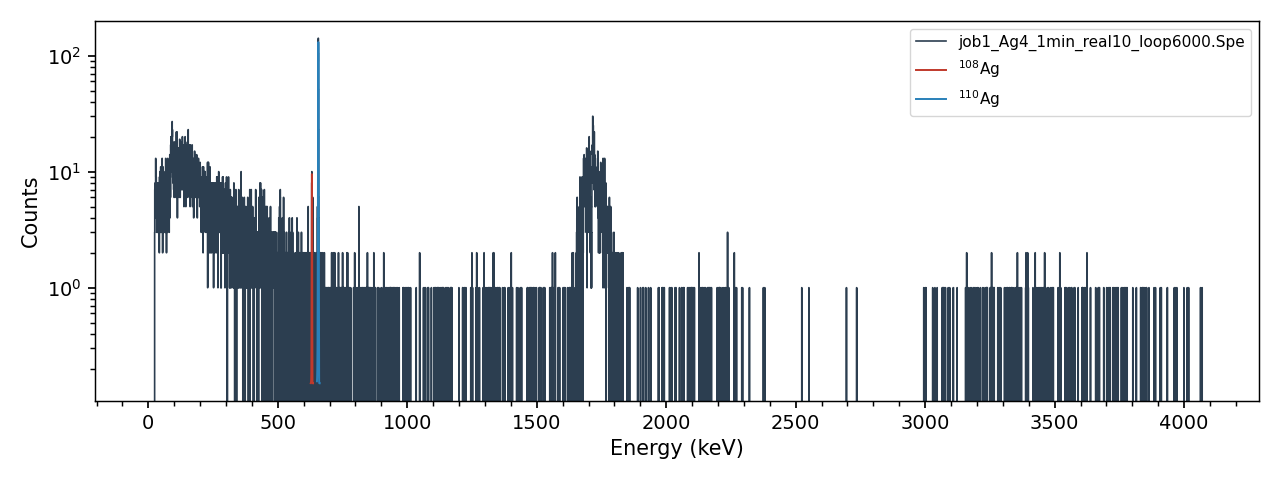

In [12]:
job_name = 'job1_Ag4_1min_real10_loop6'
spec_path = spec_exp_path / (job_name + '000.Spe')

sp1 = ci.Spectrum(spec_path)
# Note: Can use the calibration object created above, but we already saved it to a file
# sp1.cb = cb
sp1.cb = ci.Calibration(root_path / 'calibration.json')
sp1.isotopes = ['108AG', '110AG']


print(sp1.summarize())
print(sp1.peaks['isotope'])
sp1.peaks
print('---')
print(sp1.peaks['counts'].array)


print()
print('Counts for isotopes:')
counts = get_counts(sp1)
print(counts)


sp1.plot(return_plot=True)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6001.Spe
108AG - 433.96 keV (I = 0.5%)
-----------------------------
counts: 26 +/- 5
decays: 2.419e+05 +/- 7.213e+04
activity (Bq): 2.419e+04 +/- 7.213e+03
activity (uCi): 6.537e-01 +/- 1.949e-01
chi2/dof: 1.543


108AG - 632.98 keV (I = 1.76%)
------------------------------
counts: 31 +/- 5
decays: 1.037e+05 +/- 2.652e+04
activity (Bq): 1.037e+04 +/- 2.652e+03
activity (uCi): 2.802e-01 +/- 7.166e-02
chi2/dof: 1.516


110AG - 657.5 keV (I = 4.5%)
----------------------------
counts: 320 +/- 14
decays: 4.178e+05 +/- 3.854e+04
activity (Bq): 4.178e+04 +/- 3.854e+03
activity (uCi): 1.129e+00 +/- 1.042e-01
chi2/dof: 1.296


None
0    108AG
1    108AG
2    110AG
Name: isotope, dtype: object
---
<NumpyExtensionArray>
[26.66623270881777, 31.873431083603947, 320.5436318783905]
Length: 3, dtype: float64

Counts for isotopes:
{'108AG': 58.53966379242172, '110AG': 320.5436318783905}


(<Figure size 1280x480 with 1 Axes>,
 <Axes: xlabel='Energy (keV)', ylabel='Counts'>)

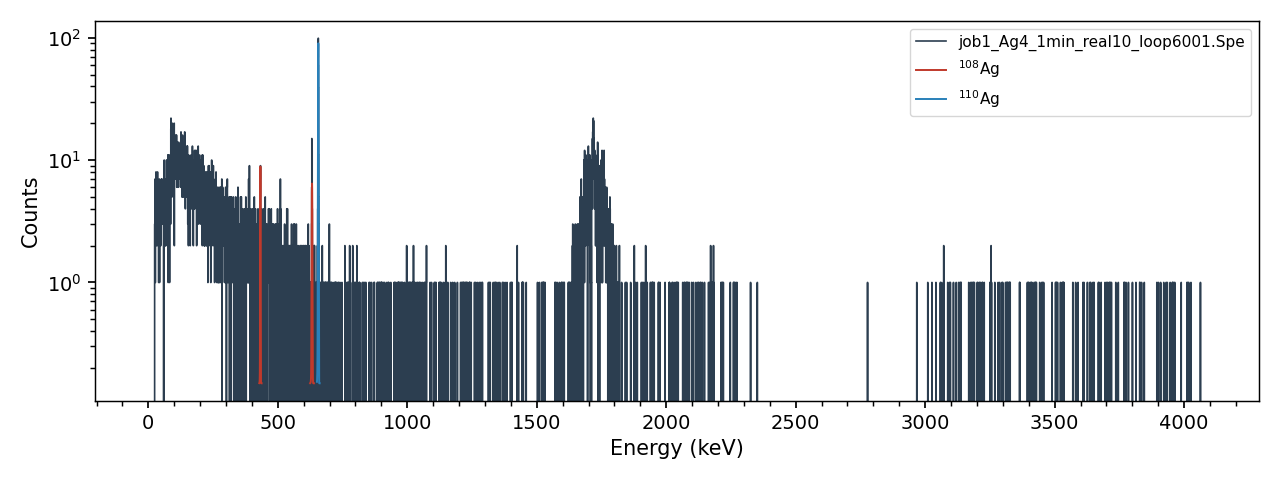

In [9]:
job_name = 'job1_Ag4_1min_real10_loop6'
spec_path = spec_exp_path / (job_name + '001.Spe')

sp1 = ci.Spectrum(spec_path)
# Note: Can use the calibration object created above, but we already saved it to a file
# sp.cb = cb
sp1.cb = ci.Calibration(root_path / 'calibration.json')
sp1.isotopes = ['108AG', '110AG']

print(sp1.summarize())
print(sp1.peaks['isotope'])
print('---')
print(sp1.peaks['counts'].array)

print()
print('Counts for isotopes:')
counts = get_counts(sp1)
print(counts)


sp1.plot(return_plot=True)

In [10]:
# TODO: 
# 1. Iterate over all epxeriment loops and plot activity. How to plot activity over a time period? Just take the average and plot in the middle of the time period? Just divide by the number of seconds and plot in the middle of the time period?
# 2. Interpolate the activity to get the activity at the time of irradiation
# 3. Make into a class/function that can be reused for other jobs
# 4. Calculate cross-section